In [1]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

In [2]:
X_raw=pd.read_csv("X.csv",index_col=0)
Y_raw=pd.read_csv("Y.csv",index_col=0,names=["Y"])

In [3]:
X_raw.describe()

,0,1,2,3,4
count,9998.000000,9997.000000,9999.000000,9999.000000,9989.000000
mean,1.019668,0.049666,0.105662,0.336831,1.039732
std,100.046328,5.460705,10.024619,59.783231,2.130112
min,-7.654205,-19.706080,-3.726699,-3001.334527,-7.265781
25%,-1.303399,-3.634017,-0.597181,-3.908743,-0.403526
50%,0.012223,0.047400,0.008015,0.050861,1.031119
75%,1.359710,3.699935,0.613412,4.135978,2.475406
max,10001.660383,19.256933,998.329754,5134.656374,9.896021


We can see that counts don't match, so there are some NAN's that we have to deal with. Since the total number of NAN's is really small (10-15 out of 1000 datapoints), in my opinion the best way is to disregard rows that have NAN's.

We also see that the standard deviations of features vary a lot (from 100 for feature 0 to 2 for 4), so before applying OLS (or other methods) it is probably better to preprocess (rescale) features.

Finally, we see that in certain features there are maximoms and minimums way outside of expected range. In practice I would spend some time figuring out if this data is correct (maybe there was an error recording data). If it is actually right, we have to analyze those outliers in more detail. Here I will analyze it a bit further and probably drop them. We sholud be really careful about using this model if those outliers actually represent valid data points.

In [4]:
Y_raw.describe()

,Y
count,10000.000000
mean,1.183616
std,54.743893
min,-712.340073
25%,-17.473542
50%,1.943772
75%,21.275091
max,681.761316


In [47]:
df=pd.concat([X_raw,Y_raw],axis=1)
df.dropna(inplace=True)

<AxesSubplot:>

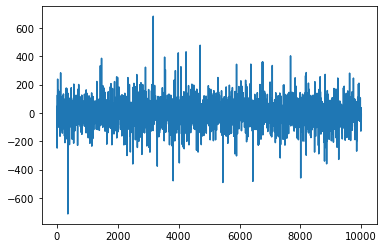

In [6]:
df['Y'].plot()

We can see that maybe there is some autocorrelation for Y? (Leave it for later analysis)

Text(0.5, 1.0, 'Y')

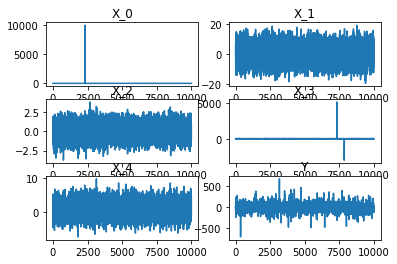

In [7]:

fig, axs=plt.subplots(3,2)
axs[0,0].plot(df['0'])
axs[0,0].set_title('X_0')
axs[0,1].plot(df['1'])
axs[0,1].set_title('X_1')
axs[1,0].plot(df['2'])
axs[1,0].set_title('X_2')
axs[1,1].plot(df['3'])
axs[1,1].set_title('X_3')
axs[2,0].plot(df['4'])
axs[2,0].set_title('X_4')
axs[2,1].plot(df['Y'])
axs[2,1].set_title('Y')

We see that there are 3 outliers that have very different characteristics from other observations. As I mentioned before, in practice we should analyze why those observations happen and probably deal with them separately. Here I will just drop those observations. We should reiterate that if those were valid observation, our model wouldn't work very well in this type of scenarios.

In [8]:
outliers=set(())
outliers.add(df['0'].idxmax())
outliers.add(df['3'].idxmax())
outliers.add(df['3'].idxmin())
outliers

{2315, 7321, 7853}

In [9]:
df.drop(outliers,inplace=True)

Text(0.5, 1.0, 'Y')

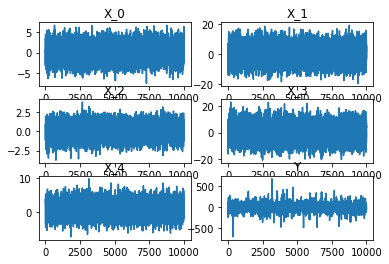

In [10]:
fig, axs=plt.subplots(3,2)
axs[0,0].plot(df['0'])
axs[0,0].set_title('X_0')
axs[0,1].plot(df['1'])
axs[0,1].set_title('X_1')
axs[1,0].plot(df['2'])
axs[1,0].set_title('X_2')
axs[1,1].plot(df['3'])
axs[1,1].set_title('X_3')
axs[2,0].plot(df['4'])
axs[2,0].set_title('X_4')
axs[2,1].plot(df['Y'])
axs[2,1].set_title('Y')

We see that we get much more reasonable looking graphs

In [11]:
X_train, X_test, Y_train, Y_test= train_test_split(df.loc[:,["0","1","2","3","4"]],df.loc[:,"Y"], random_state=4,test_size=0.2)

In [12]:
pipe=Pipeline([
    ('scaler', StandardScaler()),
    #('poly', PolynomialFeatures(degree=2)), ###tried adding quadratic terms, but didn't help much.
    ('model', LinearRegression())
])

pipeline allows us a convinient way to preprocess (rescale) X's, while not looking at the test data

In [13]:
Y_model=pipe.fit(X_train,Y_train)
Y_model.named_steps['model'].coef_

array([  3.51107364,   7.30536284,  -1.38572714, -10.02718698,
         0.36148363])

In [14]:
df_train=pd.concat([X_train,Y_train], axis=1)
df_train.corr()

,0,1,2,3,4,Y
0,1.000000,-0.299814,0.191888,0.294073,-0.181224,-0.036132
1,-0.299814,1.000000,0.402702,0.195061,0.887299,0.074861
2,0.191888,0.402702,1.000000,0.285080,0.602030,-0.007580
3,0.294073,0.195061,0.285080,1.000000,0.230967,-0.145337
4,-0.181224,0.887299,0.602030,0.230967,1.000000,0.056375
Y,-0.036132,0.074861,-0.007580,-0.145337,0.056375,1.000000


After dropping the outliers we see that we get some (even though still small) correlation of Y with X's)

In [15]:
Y_model.score(X_train,Y_train)

0.03518950509068497

We see that even on the train data, the OLS model is really bad (but a bit better than a constant estimate) (r^2 score of about 0.04)

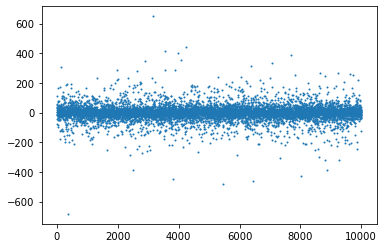

In [16]:
plt.scatter(Y_train.index,Y_train-Y_model.predict(X_train),s=1)

In [17]:
(Y_train-Y_model.predict(X_train)).describe()

count    7.986000e+03
mean    -3.532250e-16
std      5.326791e+01
min     -6.834435e+02
25%     -1.783719e+01
50%      9.113884e-01
75%      1.909408e+01
max      6.497447e+02
Name: Y, dtype: float64

We see that the model is unbiased (on training data), but has considerable variance. This is also reaffirmed by the test data.

In [18]:
Y_model.score(X_test,Y_test)

0.05341639451636926

In [19]:
(Y_test-Y_model.predict(X_test)).describe()

count    1997.000000
mean        0.572400
std        55.205566
min      -370.369695
25%       -17.302575
50%         0.190840
75%        19.036982
max       498.413818
Name: Y, dtype: float64

I tried applying some variations of OLS (ridge with cv), but the result wasn't much better. Let's use the hint and see if the sqared error is spherical. OLS is not guaranteed to provide a best unbiased classification if the error is not spherical

In [20]:
Er_sq=(Y_train-Y_model.predict(X_train))**2
Er_sq.rename('Squared error',inplace=True)

3728       2.124426
230        0.399528
2661     841.566285
486     1757.565929
1620     291.049716
           ...     
458       78.786742
6032     667.422608
711      131.195855
8383    3980.101927
1148    1116.916031
Name: Squared error, Length: 7986, dtype: float64

In [21]:
pipe_er=Pipeline([
    ('scaler', StandardScaler()),
    #('poly', PolynomialFeatures(degree=2)), ###tried adding quadratic terms, but didn't help much.
    ('model', LinearRegression())
])
Er_model=pipe_er.fit(X_train,Er_sq)

In [22]:
Er_model.named_steps['model'].coef_

array([  13.2826096 ,  496.43916632, -185.73625754,  789.46962472,
       -368.36591611])

Some coefficients are really big, so we should use a shrinkage method)

In [23]:
Er_model.score(X_train,Er_sq)

0.004537157174403728

We see that linear model for Error squared doesn't really give us much

In [24]:
pd.concat([df_train,Er_sq],axis=1).corr()

,0,1,2,3,4,Y,Squared error
0,1.000000,-0.299814,0.191888,0.294073,-0.181224,-0.036132,0.010576
1,-0.299814,1.000000,0.402702,0.195061,0.887299,0.074861,0.020272
2,0.191888,0.402702,1.000000,0.285080,0.602030,-0.007580,0.001658
3,0.294073,0.195061,0.285080,1.000000,0.230967,-0.145337,0.062286
4,-0.181224,0.887299,0.602030,0.230967,1.000000,0.056375,0.011613
Y,-0.036132,0.074861,-0.007580,-0.145337,0.056375,1.000000,-0.064868
Squared error,0.010576,0.020272,0.001658,0.062286,0.011613,-0.064868,1.000000


We see that X_3 is strongly correlated with the squared error.

Text(0, 0.5, 'Error squared')

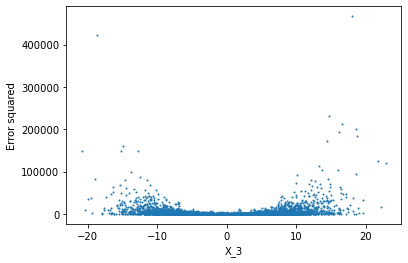

In [25]:
X_train_3=df_train.loc[:,'3']
plt.scatter(X_train_3,Er_sq, s=1)
plt.xlabel("X_3")
plt.ylabel("Error squared")

We see indeed from the graph that there is a strong correlation between X_3 and Squared errors. We also see that it is not really linear (that's why the regression above of Sq_er on X didn't provide a good model) and looks more like exponential or quadratic. Let's try using a linear regression of Error_squared on X_3, X_3^2

In [26]:
pipe_sq_3=Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])

In [27]:
X_train_3.values.reshape(-1, 1)
Er_square_model_3=pipe_sq_3.fit(X_train_3.values.reshape(-1, 1),Er_sq)
Er_square_model_3.named_steps['model'].coef_

array([   0.        ,  617.09892362, 4027.71072923])

In [28]:
Er_square_model_3.score(X_train_3.values.reshape(-1, 1),Er_sq)

0.22902776689189352

We see that this model is somewhat descriptive (r^2 score of about 0.25 on train set)

Text(0, 0.5, 'Error squared')

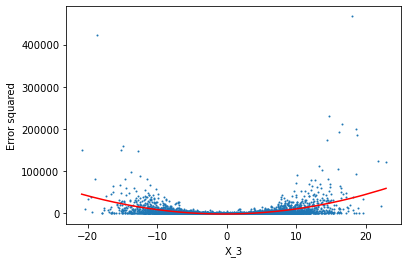

In [29]:
x_3_ord, y_ord=zip(*sorted(zip(X_train_3,Er_square_model_3.predict(X_train_3.values.reshape(-1, 1)))))
plt.plot(x_3_ord, y_ord, 'r')
plt.scatter(X_train_3,Er_sq, s=1)
plt.xlabel("X_3")
plt.ylabel("Error squared")

Just making sure that it actually works

Now we can at least use weighted OLS with the weigth we get from this last model for error squared.

Let's try to see if we can also predict the sign of the error based on the data

In [30]:
pd.concat([df_train,Er_sq,np.sign(Y_train-Y_model.predict(X_train)).rename('error sign',inplace=True)],axis=1).corr()

,0,1,2,3,4,Y,Squared error,error sign
0,1.000000,-0.299814,0.191888,0.294073,-0.181224,-0.036132,0.010576,0.009461
1,-0.299814,1.000000,0.402702,0.195061,0.887299,0.074861,0.020272,-0.009973
2,0.191888,0.402702,1.000000,0.285080,0.602030,-0.007580,0.001658,0.021616
3,0.294073,0.195061,0.285080,1.000000,0.230967,-0.145337,0.062286,0.005235
4,-0.181224,0.887299,0.602030,0.230967,1.000000,0.056375,0.011613,-0.001976
Y,-0.036132,0.074861,-0.007580,-0.145337,0.056375,1.000000,-0.064868,0.591600
Squared error,0.010576,0.020272,0.001658,0.062286,0.011613,-0.064868,1.000000,-0.015840
error sign,0.009461,-0.009973,0.021616,0.005235,-0.001976,0.591600,-0.015840,1.000000


We see that the error sign doesn't correlate that well with any of the features. In practice it is probably something worth exploring more, since some correlations are non-zero, notably correlation with X_3 is about -.15.but  In this case I am not going to explore it further

In [31]:
pipe_sq=Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])

In [32]:
Er_sq_model=pipe_sq.fit(X_train,Er_sq)

In [33]:
Er_sq_model.score(X_train,Er_sq)

0.2369024004134863

We see that adding other variables besides X_3 didn't improve the model predictivness by much, while probably introducing unnecesary variance. For this reason I will use the model that only uses X_3. In practice it would be a good idea to run cross-validation and pick a best subset. 

In [34]:
Er_sq_predict=Er_square_model_3.predict(X_train_3.values.reshape(-1, 1))
Er_sq_predict[Er_sq_predict<0]=0
Er_sq_predict

array([   0.        ,   99.1776035 ,    0.        , ..., 4664.94754832,
       3514.4336065 ,  961.61875109])

In [35]:
weight=1/(abs(np.array(Er_sq_predict))+1)
(abs(np.array(Er_sq_predict))+1).min()

1.0

this weight increases when the absolute value of expected error increases, while not being unboun

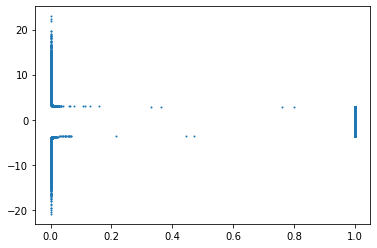

In [36]:
plt.scatter(weight,X_train_3,s=1)

In [37]:
weighted_linear_regression=LinearRegression().fit(X_train,Y_train,weight)
weighted_linear_regression.coef_

array([ 1.34755715,  1.17419284, -0.28082503, -1.80601798, -0.21673697])

In [38]:
weighted_linear_regression.score(X_train,Y_train)

0.03403611870502843

We see that the model is still pretty bad (r^2 score of about 0.04)

In [39]:
weighted_linear_regression.score(X_test,Y_test)

0.05517517737212796

In [40]:
Y_model.score(X_test,Y_test)

0.05341639451636926

We see that accounting for not spherical error terms didn't help much. One other idea would be to try to study autocorrelation of Y (if it's time series for example), and see if that help. I am not sure I have time to properly go into it, but let me look at least wether autocorrelation is present or not.

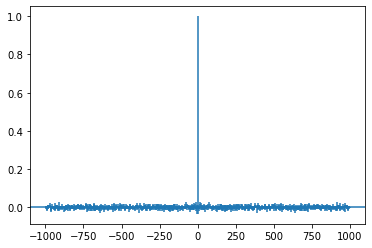

In [41]:
acor=plt.acorr(Y_raw['Y'],maxlags=1000)


Doen't seem like there is a strong autocorreation either.

Unfortunately I was unable to produce a really predictive model. With all the above models the R^2 score is really low. However, even though it is low, it is consistently positive (around 0.05), and might still be useful in some applications. Even though only OLS is demonstrated, tests on other variants of linear regression produced similar results. Computing coefficients ([ 1.34755715,  1.17419284, -0.28082503, -1.80601798, -0.21673697]) also illustarate that probably there is not much merit in shrinkage methods (since they are already not large in magnitude). Applying some postprocessing of Y's might help too.

We also illustrated a pretty good model for estimating squared error using X_3 feature, which might be useful when determining how good a prediction (possibly using a different model) is expected to be. In particular, We see that for small values of X_3, sqaured error is relatively small, so we can expect to find a reasonable approximation for Y-value for such samples. 

I also had a quick look at autocorrelation of Y, but was unable to establish one. Some more advanced models might prove to be useful, e.g. trying to correlate y_i to a collection of previous y's (instead of just 1), for example to the moving median (or mean).

In [42]:
df_small=df.loc[(df["3"]<10) & (df["3"]>-10)]
df_small.describe()

,0,1,2,3,4,Y
count,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000
mean,0.021878,0.020939,0.005119,0.072945,1.030056,1.531767
std,1.964683,5.432109,0.890970,4.775307,2.113387,37.669460
min,-7.654205,-19.706080,-3.726699,-9.991895,-7.265781,-292.564377
25%,-1.283909,-3.653853,-0.587873,-3.490176,-0.402079,-15.331738
50%,0.006382,0.024415,0.008015,0.033522,1.019824,1.948709
75%,1.340573,3.665558,0.604665,3.598540,2.458829,19.331699
max,6.766637,19.256933,3.761865,9.993566,9.896021,230.513157


In [43]:
X_s_train, X_s_test, Y_s_train, Y_s_test= train_test_split(df_small.loc[:,["0","1","2","3","4"]],df_small.loc[:,"Y"], random_state=4,test_size=0.2)

In [44]:
Small_x_model=LinearRegression(normalize=True).fit(X_s_train,Y_s_train)

In [45]:
Small_x_model.score(X_s_train,Y_s_train)

0.04744767637639713

In [48]:
Small_x_model.score(X_s_test,Y_s_test)

0.05216672372453923

We see that even limiting ourself to samples with small X_3, there seemingly is no significant improvement in the R^2 score. Again, in practice this is also probably a part that needs to be studied more (since as mentioned above, the variance of Y's is much lower with these restrictions). It is also worth mentioning that this still covers 90% of the data points.